In [3]:
!wget http://1002genomes.u-strasbg.fr/files/Diallel_RNAseq/ASE/Datafile2_ase_sum_20230609.tab

--2024-04-26 23:53:50--  http://1002genomes.u-strasbg.fr/files/Diallel_RNAseq/ASE/Datafile2_ase_sum_20230609.tab
Resolving 1002genomes.u-strasbg.fr (1002genomes.u-strasbg.fr)... 130.79.18.41
Connecting to 1002genomes.u-strasbg.fr (1002genomes.u-strasbg.fr)|130.79.18.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134196476 (128M) [text/plain]
Saving to: ‘Datafile2_ase_sum_20230609.tab’

Datafile2_ase_sum_2 100%[===================>] 127.98M  26.1MB/s    in 8.1s    

2024-04-26 23:53:59 (15.7 MB/s) - ‘Datafile2_ase_sum_20230609.tab’ saved [134196476/134196476]



In [1]:
import numpy as np
import pandas as pd
from scipy import stats
np.random.seed(307203)

# plotting
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Datafile2_ase_sum_20230609.tab')

/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_41094/1986986463.py:1: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datafile2_ase_sum_20230609.tab')


-----
# Hypothesis testing 

## Binomial test for $H1 = H2$

In [ ]:

N = len(df)
# N = 10000

binom_pvals = np.empty(N)


for i in range(N):
  print(i)
#   if (i^100) == 0:
#     print(i)
  parent_1 = int(np.round(df.loc[i,'P1_2n_count']))
  parent_2 = int(np.round(df.loc[i,'P2_2n_count']))
  hybrid_1 = int(np.round(df.loc[i,'P1_count']))
  hybrid_2 = int(np.round(df.loc[i,'P2_count']))

  result_binom = stats.binomtest(hybrid_1, n=hybrid_1 + hybrid_2, p=0.5, alternative='two-sided')
  binom_pvals[i] = result_binom.pvalue

    
    
np.save('./results/binom_pvals_Tsouris',binom_pvals)





## Bivariate binomial test for $\frac{P1}{P1+P2} = \frac{H1}{H1+H2}$

In [ ]:
N = len(df)
# N = 100
print(N)

binom_pvals = np.empty(N)
bi_binom_pvals = np.empty(N)


for i in range(N):
  print(i)
#   if (i^100) == 0:
#     print(i)
  parent_1 = int(np.round(df.loc[i,'P1_2n_count']))
  parent_2 = int(np.round(df.loc[i,'P2_2n_count']))
  hybrid_1 = int(np.round(df.loc[i,'P1_count']))
  hybrid_2 = int(np.round(df.loc[i,'P2_count']))
    
  p_theoretical = (parent_1+hybrid_1)/(parent_1+parent_2+hybrid_1+hybrid_2)

  p_obs_p = stats.binom.pmf(k = parent_1,
                            n = parent_1+parent_2,
                            p = p_theoretical)
  p_obs_h = stats.binom.pmf(k = hybrid_1,
                            n = hybrid_1+hybrid_2,
                            p = p_theoretical)
  p_obs = p_obs_p*p_obs_h
    
    
  prob_P_array = stats.binom.pmf(k = np.arange(0,parent_1+parent_2+1), 
                                 n = parent_1+parent_2 , 
                                 p = p_theoretical).reshape(-1,1).repeat(hybrid_1+hybrid_2+1,axis=1)
  prob_H_array = stats.binom.pmf(k = np.arange(0,hybrid_1+hybrid_2+1), 
                                 n = hybrid_1+hybrid_2, 
                                 p = p_theoretical).reshape(1,-1).repeat(parent_1+parent_2+1,axis=0)
  
  prob_array = prob_P_array*prob_H_array 
  p_sum = np.sum(prob_array[prob_array<=p_obs])
  bi_binom_pvals[i] = p_sum
    
    

np.save('./results/binom_ratio_pvals_Tsouris',bi_binom_pvals)






ave('./bi_binom_pvals_Tsouris',bi_binom_pvals)

## Raw p-value distributions

In [31]:
binom_pvals = np.load('./results/binom_pvals_Tsouris.npy')
bi_binom_pvals = np.load('./results/binom_ratio_pvals_Tsouris.npy')

df['binom_pvals_uncorrected'] = binom_pvals
df['bi_binom_pvals_uncorrected'] = bi_binom_pvals


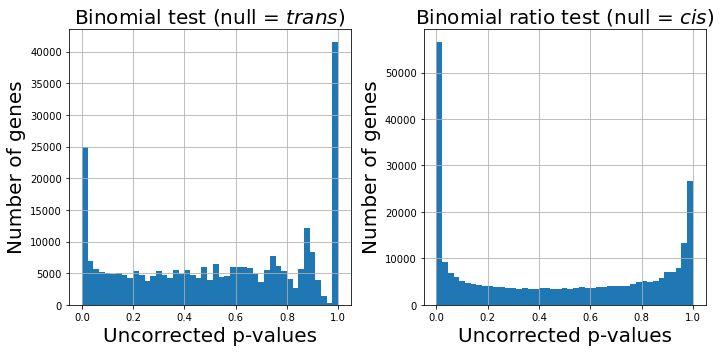

In [32]:
# what do the p-value distributions look like?
fs = 20
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(binom_pvals,density=False,bins = 45)
ax[0].set_title('Binomial test (null = $trans$)',fontsize=fs)
ax[0].set_xlabel('Uncorrected p-values',fontsize=fs)
ax[0].set_ylabel('Number of genes',fontsize=fs)
ax[0].grid()

ax[1].hist(bi_binom_pvals,bins = 45,density=False)
ax[1].set_title('Binomial ratio test (null = $cis$)',fontsize=fs)
ax[1].set_xlabel('Uncorrected p-values',fontsize=fs)
ax[1].set_ylabel('Number of genes',fontsize=fs)
ax[1].grid()

plt.tight_layout()
plt.savefig('./figs/uncorrected_pvals',dpi=450,bbox_inches='tight')

## Correct for multiple testing using Benjamini-Hochberg.

In [5]:
df['sample-gene'] = df['sampleID']+df['GeneID']
sample_gene = df['sample-gene'].values.flatten()

num_test = len(binom_pvals)

# sort p values
sorted_binom_genes = [g for _,g in sorted(zip(binom_pvals,sample_gene))]
sorted_binom_pvals = [p for p,_ in sorted(zip(binom_pvals,sample_gene))]

# calculate FDR for each gene
fdr_binom = np.arange(1,num_test+1)/num_test * sorted_binom_pvals

# create df
df_binom = pd.DataFrame({'fdr_binom' : sorted_binom_pvals, 'sample-gene' : sorted_binom_genes})

# sort p values
sorted_bi_binom_genes = [g for _,g in sorted(zip(bi_binom_pvals,sample_gene))]
sorted_bi_binom_pvals = [p for p,_ in sorted(zip(bi_binom_pvals,sample_gene))]

# calculate FDR for each gene
fdr_bi_binom = np.arange(1,num_test+1)/num_test * sorted_bi_binom_pvals

# create df
df_bi_binom = pd.DataFrame({'fdr_bi_binom' : sorted_bi_binom_pvals, 'sample-gene' : sorted_bi_binom_genes})

# merge 
df_binom = df_binom.merge(df_bi_binom,on='sample-gene')

df = df.merge(df_binom,on='sample-gene')



## Corrected p-value (FDR) distributions

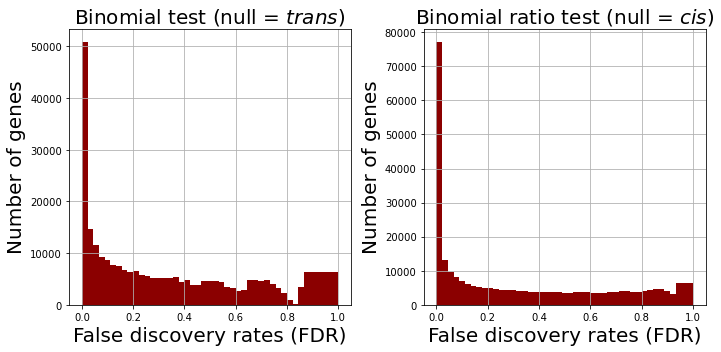

In [6]:
# histogram of corrected p values

# what do the p-value distributions look like?
fs = 20
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(fdr_binom,density=False,bins = 45,color = 'darkred')
ax[0].set_title('Binomial test (null = $trans$)',fontsize=fs)
ax[0].set_xlabel('False discovery rates (FDR)',fontsize=fs)
ax[0].set_ylabel('Number of genes',fontsize=fs)
ax[0].grid()

ax[1].hist(fdr_bi_binom,bins = 45,density=False, color = 'darkred')
ax[1].set_title('Binomial ratio test (null = $cis$)',fontsize=fs)
ax[1].set_xlabel('False discovery rates (FDR)',fontsize=fs)
ax[1].set_ylabel('Number of genes',fontsize=fs)
ax[1].grid()

plt.tight_layout()
plt.savefig('./figs/corrected_fdr',dpi=450,bbox_inches='tight')

# Gene regulatory assignments based on FDRs

In [7]:
FDR = 0.05

# Assign our new regulatory groups
P = df['Parlog2FC'].values.flatten()
H = df['Hyblog2FC'].values.flatten()
delta = P - H

ordered_fdr_ztest = df['bi_binom_pvals_uncorrected'].values.flatten()
ordered_fdr_binom = df['binom_pvals_uncorrected'].values.flatten()


# make OUR new regulation assignments:
new_reg_assignments = np.empty(len(delta), dtype=object)

# cis
index = (ordered_fdr_binom<=FDR) & (ordered_fdr_ztest>FDR)
new_reg_assignments[index] = 'cis'

# trans
index = (ordered_fdr_binom>FDR) & (ordered_fdr_ztest<=FDR)
new_reg_assignments[index] = 'trans'

# cis x trans
index = (ordered_fdr_binom<=FDR) & (ordered_fdr_ztest<=FDR) & (delta*H<=0)
new_reg_assignments[index&index] = 'cis x trans'

# cis + trans
index = (ordered_fdr_binom<=FDR) & (ordered_fdr_ztest<=FDR) & (delta*H>=0)
new_reg_assignments[index&index] = 'cis + trans'

# conserved
index = (ordered_fdr_binom>FDR) & (ordered_fdr_ztest>FDR)
new_reg_assignments[index] = 'conserved'


df['new_reg_group_fdr'] = new_reg_assignments

-----
# Comparing reported and transformed regulatory assignments

In [12]:
# rename the NaN regulatory group to 'Undefined'
df['reg_group'] = df['reg_group'].fillna('conserved')
reg_groups = df['reg_group'].unique()

In [13]:
color_dict = {'cis' : 'orangered',
              'cis + trans' : 'skyblue',
              'cis x trans' : 'forestgreen',
              'trans' : 'royalblue',
               'conserved' : 'lightgray'}
label_dict = {'cis' : '$cis$ only',
              'cis + trans' : 'cis + trans',
              'cis x trans' : 'cis x trans',
              'trans' : '$trans$ only',
               'conserved' : 'null'}


In [14]:
# recode to make four possible reg groups for OLD method

P = df['Parlog2FC'].values.flatten()
H = df['Hyblog2FC'].values.flatten()

delta = P - H
scaled_theta = (2/np.pi) * np.arctan( H / (delta) ) # scaled theta
R = np.sqrt(delta**2  + H**2)
df['delta'] = delta
df['theta'] = np.arctan( H / (delta) )
df['theta_scaled'] = (2/np.pi) * np.arctan( H / (delta) )
df['R'] = np.sqrt( (delta) **2 + H**2)


# recode THEIR reg groups
new_reg_assignments_theirs = np.empty(len(scaled_theta), dtype=object)

# cis + trans
index = ((delta > 0) & (H > 0)) | ( (delta < 0) & (H < 0) )
new_reg_assignments_theirs[index] = 'cis + trans'

# cis x trans
index = ((delta <= 0) & (H >= 0)) | ( (delta >= 0) & (H <= 0) )
new_reg_assignments_theirs[index] = 'cis x trans'


# cis
index = df['reg_group'].values == 'cis'
new_reg_assignments_theirs[index] = 'cis'

# trans
index = df['reg_group'].values == 'trans'
new_reg_assignments_theirs[index] = 'trans'

# null
index = df['reg_group'].values == 'conserved'
new_reg_assignments_theirs[index] =  'conserved'

df['new_reg_group_theirs'] = new_reg_assignments_theirs


/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_41094/1866502901.py:7: RuntimeWarning: invalid value encountered in divide
  scaled_theta = (2/np.pi) * np.arctan( H / (delta) ) # scaled theta
/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_41094/1866502901.py:10: RuntimeWarning: invalid value encountered in divide
  df['theta'] = np.arctan( H / (delta) )
/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_41094/1866502901.py:11: RuntimeWarning: invalid value encountered in divide
  df['theta_scaled'] = (2/np.pi) * np.arctan( H / (delta) )


## Reported regulatory assignments

In [15]:
# add column of color to dataframe
df['color_reported'] = [color_dict[reg_] for reg_ in df['new_reg_group_theirs'].values]
df['color_fdr'] = [color_dict[reg_] for reg_ in df['new_reg_group_fdr'].values]

In [16]:
reg_groups = ['cis x trans','cis + trans','trans','cis','conserved']

/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_32575/4262271639.py:16: RuntimeWarning: invalid value encountered in divide
  theta_scaled = (2/np.pi) * np.arctan(H / delta)


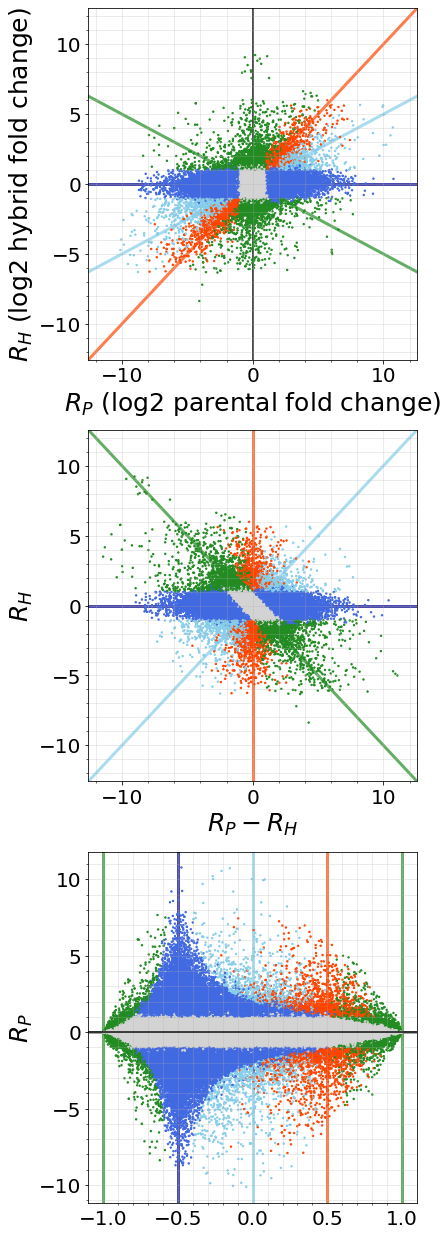

In [34]:
# random order
fig, ax = plt.subplots(3, 1, figsize=(6, 23*(3/4)))

s = 2
alpha = 1.0
axis_fs = 25
title_fs = 18
label_fs = 20
line_color = 'black'
axis_width = 3.0
line_alpha = 0.7

P = df['Parlog2FC'].values.flatten()
H = df['Hyblog2FC'].values.flatten()
delta = P - H
theta_scaled = (2/np.pi) * np.arctan(H / delta)
R = np.sqrt(delta**2 + H**2)
cis_prop_reordered = theta_scaled-0.5
cis_prop_reordered[cis_prop_reordered<=-1.0] = (cis_prop_reordered[cis_prop_reordered<=-1.0]) + 2.0

colors = df['color_reported'].values

random_idx = np.arange(0,len(colors))
np.random.shuffle(random_idx)


ax[0].scatter(P[random_idx],H[random_idx],s = s, alpha = alpha, c = colors[random_idx])
ax[0].set_xlabel('$R_{P}$ (log2 parental fold change)', fontsize = axis_fs)
ax[0].set_ylabel('$R_{H}$ (log2 hybrid fold change)', fontsize = axis_fs)

ax[1].scatter(P[random_idx]-H[random_idx],H[random_idx],s=s,alpha=alpha,  c = colors[random_idx])
ax[1].set_xlabel('$R_{P} - R_{H}$',fontsize = axis_fs)
ax[1].set_ylabel('$R_{H}$',fontsize = axis_fs)

ax[2].scatter(cis_prop_reordered[random_idx], P[random_idx] ,s = s, alpha = alpha, c=colors[random_idx])
# ax[2].set_xlabel(r'$\frac{2}{\pi} \theta$ (scaled angle from $trans$ axis)',fontsize=axis_fs)
ax[2].set_ylabel('$R_{P}$',fontsize=axis_fs)

for i in range(2):
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=axis_fs)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=axis_fs)
    ax[i].tick_params(axis='both', labelsize=label_fs)
    ax[i].grid(which='both', alpha=0.5, linewidth=0.5)
    ax[i].minorticks_on()


# Determine the diagonal points for the line y = x
x_min, x_max = ax[i].get_xlim()
y_min, y_max = ax[i].get_ylim()
diag_val = max( np.abs(x_min), np.abs(x_max), np.abs(y_min), np.abs(y_max) )
# ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
# ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')
# ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
# ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')


x = np.linspace(-diag_val, diag_val, 100) 
ax_ = ax[0]
ax_.plot(x, x, color='orangered', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.plot(x+x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.plot(-x-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)
# ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')
ax_.axvline(0, color='black', linewidth=2, alpha=0.7, linestyle='-',zorder=0)
ax_.set_xlim(-diag_val, diag_val)
ax_.set_ylim(-diag_val, diag_val)

ax_ = ax[1]
ax_.axvline(0, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha = line_alpha,zorder=0)
ax_.plot(x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.plot(-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.set_xlim(-diag_val, diag_val)
ax_.set_ylim(-diag_val, diag_val)

# Set additional grid lines for the third plot
ax_ = ax[2]
ax_.axvline(0.5, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(-0.5, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(0.0, color='skyblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(-1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axhline(0, color='gray', linewidth=axis_width, alpha = line_alpha,zorder=0)
ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')

ax[2].tick_params(axis='both', labelsize=label_fs)
ax[2].tick_params(bottom=False)
ax[2].grid(which='both', alpha=0.5, linewidth=0.5)
ax[2].minorticks_on()

ax2_xlims = ax[2].get_xlim()
ax2_ylims = ax[2].get_ylim()

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig('figs/fig2A',dpi=450,bbox_inches='tight')
plt.show();

cis x trans 6696


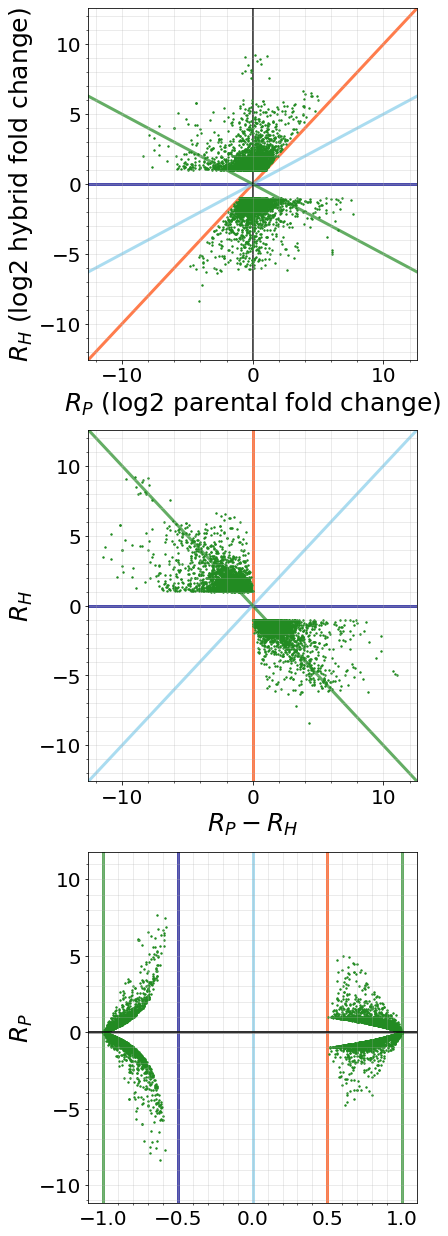

cis + trans 1727


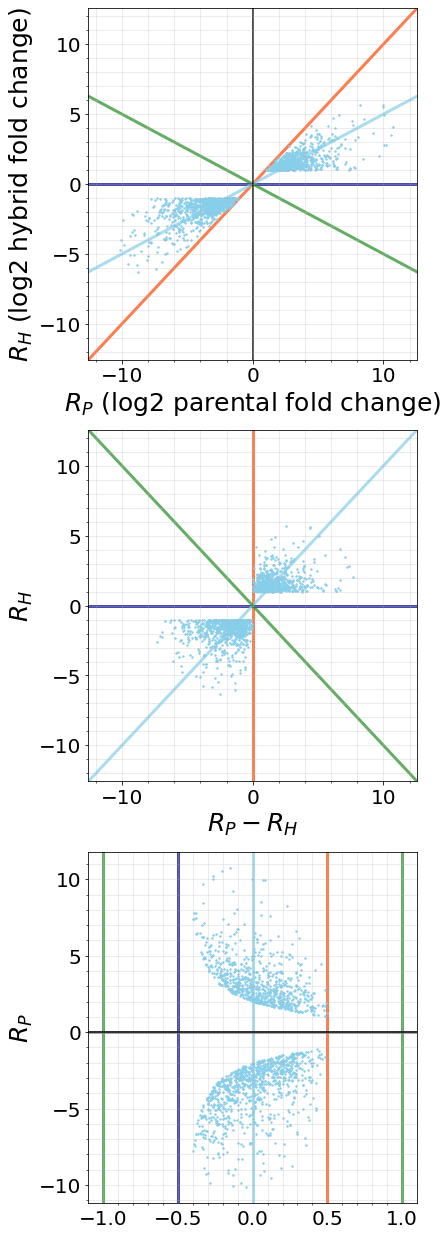

trans 57253


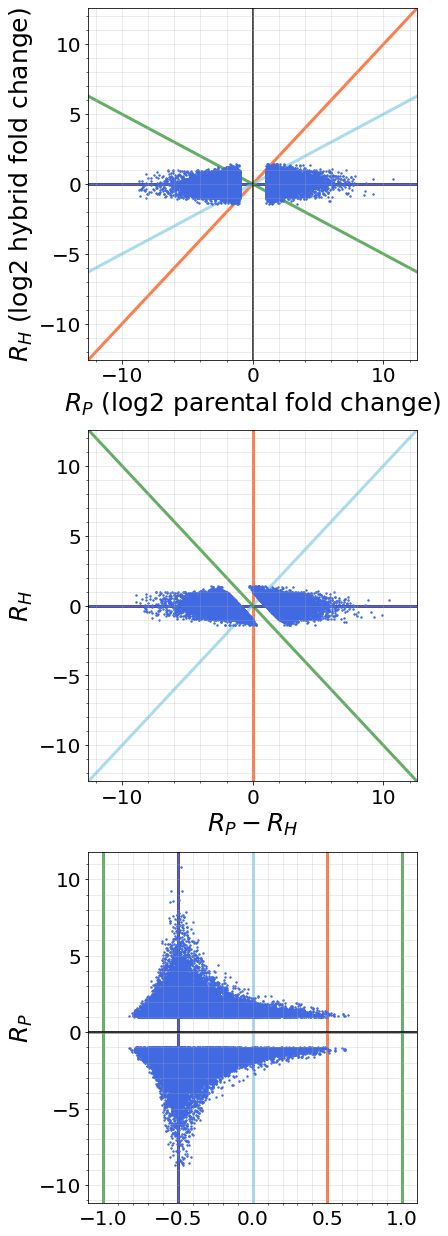

cis 2804


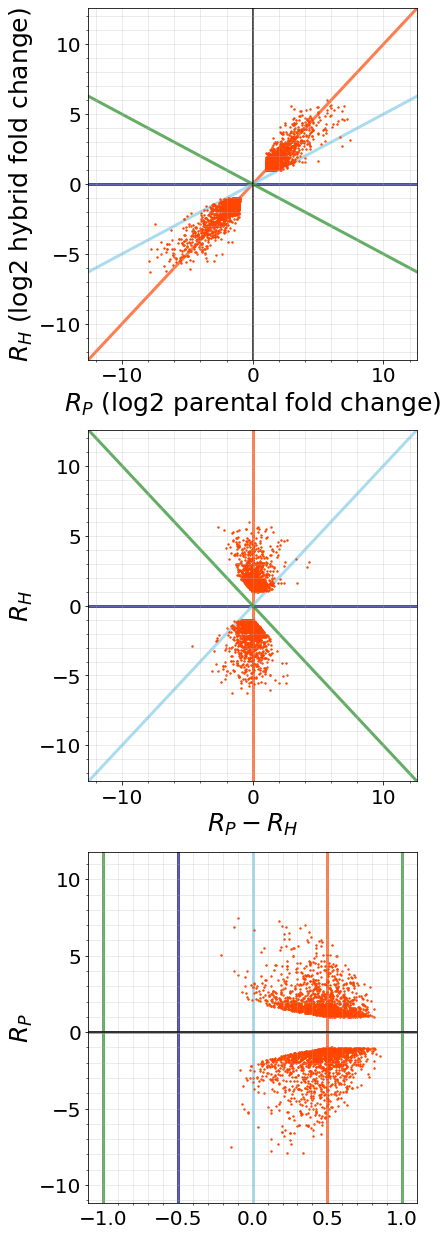

conserved 217297


/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_32575/3412658698.py:15: RuntimeWarning: invalid value encountered in divide
  theta_scaled = (2/np.pi) * np.arctan(H / delta)


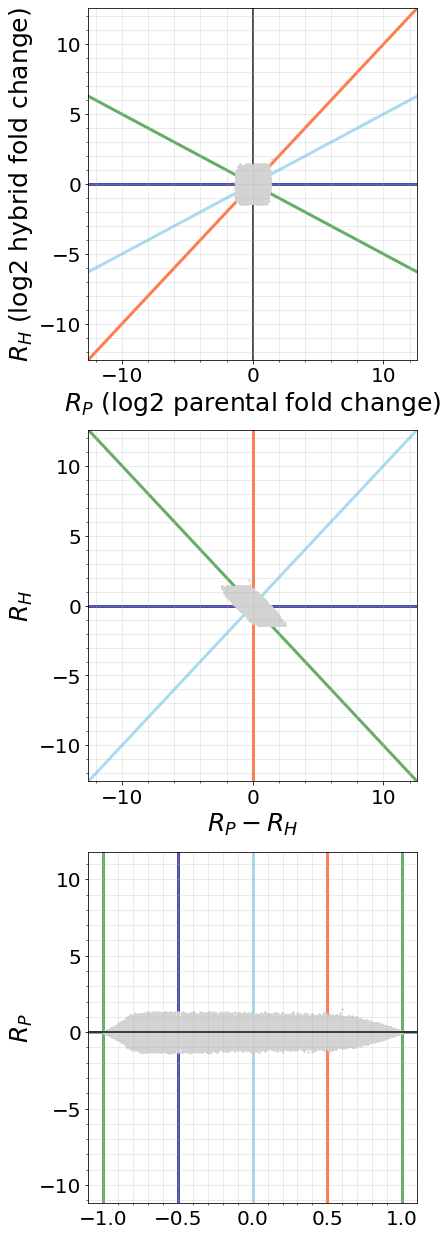

In [25]:

num_per_reg_group_theirs = []
colors = []

for reg in reg_groups:
    fig, ax = plt.subplots(3, 1, figsize=(6, 23*(3/4)))
    label = label_dict[reg]
    color = color_dict[reg]
    df_ = df[df['new_reg_group_theirs'] == reg]
    P = df_['Parlog2FC'].values.flatten()
    H = df_['Hyblog2FC'].values.flatten()
    num_per_reg_group_theirs.append(len(H))
    colors.append(color)
    print(reg,len(P))
    delta = P - H
    theta_scaled = (2/np.pi) * np.arctan(H / delta)
    R = np.sqrt(delta**2 + H**2)
    cis_prop_reordered = theta_scaled-0.5
    cis_prop_reordered[cis_prop_reordered<=-1.0] = (cis_prop_reordered[cis_prop_reordered<=-1.0]) + 2.0

    # ax[0].scatter(P, H, s=s, alpha=alpha, color=color, label=label)
    # ax[1].scatter(delta, H, s=s, alpha=alpha, color=color)
    # ax[2].scatter(theta_scaled, P, s=s, alpha=alpha, color=color)
    # ax[2].scatter(theta_scaled, R, s=s, alpha=alpha, color=color)

    ax[0].scatter(P,H,s = s, alpha = alpha, color = color, label = label)
    ax[0].set_xlabel('$R_{P}$ (log2 parental fold change)', fontsize = axis_fs)
    ax[0].set_ylabel('$R_{H}$ (log2 hybrid fold change)', fontsize = axis_fs)

    ax[1].scatter(P-H,H,s=s,alpha=alpha,  color = color)
    ax[1].set_xlabel('$R_{P} - R_{H}$',fontsize = axis_fs)
    ax[1].set_ylabel('$R_{H}$',fontsize = axis_fs)

    ax[2].scatter(cis_prop_reordered, P ,s = s, alpha = alpha,color=color)
    # ax[2].set_xlabel(r'$\frac{2}{\pi} \theta$ (scaled angle from $trans$ axis)',fontsize=axis_fs)
    ax[2].set_ylabel('$R_{P}$',fontsize=axis_fs)

    for i in range(2):
        ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=axis_fs)
        ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=axis_fs)
        ax[i].tick_params(axis='both', labelsize=label_fs)
        ax[i].grid(which='both', alpha=0.5, linewidth=0.5)
        ax[i].minorticks_on()


        # ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
        # ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')
        # ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
        # ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')
        ax[i].set_xlim(-diag_val, diag_val)
        ax[i].set_ylim(-diag_val, diag_val)


    x = np.linspace(-diag_val, diag_val, 100) 
    ax_ = ax[0]
    ax_.plot(x, x, color='orangered', linewidth=axis_width,alpha = line_alpha,zorder=0)
    ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.plot(x+x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
    ax_.plot(-x-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)
    # ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')
    ax_.axvline(0, color='black', linewidth=2, alpha=0.7, linestyle='-',zorder=0)

    ax_ = ax[1]
    ax_.axvline(0, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha = line_alpha,zorder=0)
    ax_.plot(x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
    ax_.plot(-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)



    # Set additional grid lines for the third plot
    ax_ = ax[2]
    ax_.axvline(0.5, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(-0.5, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(0.0, color='skyblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(-1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axhline(0, color='gray', linewidth=axis_width, alpha = line_alpha,zorder=0)
    ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')

    ax[2].tick_params(axis='both', labelsize=label_fs)
    ax[2].tick_params(bottom=False)
    ax[2].grid(which='both', alpha=0.5, linewidth=0.5)
    ax[2].minorticks_on()
    
    ax[2].set_xlim(ax2_xlims)
    ax[2].set_ylim(ax2_ylims)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.savefig(f'supp2B_{reg}',dpi=450,bbox_inches='tight')
    plt.show();

## Transformed regulatory assignments

/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_32575/653726682.py:16: RuntimeWarning: invalid value encountered in divide
  theta_scaled = (2/np.pi) * np.arctan(H / delta)


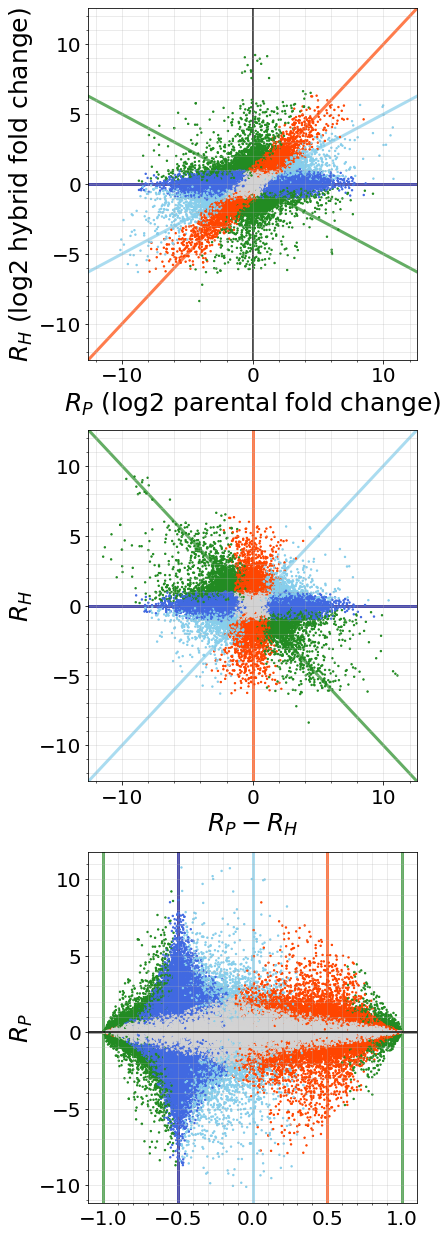

In [35]:
# random order
fig, ax = plt.subplots(3, 1, figsize=(6, 23*(3/4)))

s = 2
alpha = 1.0
axis_fs = 25
title_fs = 18
label_fs = 20
line_color = 'black'
axis_width = 3.0


P = df['Parlog2FC'].values.flatten()
H = df['Hyblog2FC'].values.flatten()
delta = P - H
theta_scaled = (2/np.pi) * np.arctan(H / delta)
R = np.sqrt(delta**2 + H**2)
cis_prop_reordered = theta_scaled-0.5
cis_prop_reordered[cis_prop_reordered<=-1.0] = (cis_prop_reordered[cis_prop_reordered<=-1.0]) + 2.0

colors = df['color_fdr'].values

random_idx = np.arange(0,len(colors))
np.random.shuffle(random_idx)


ax[0].scatter(P[random_idx],H[random_idx],s = s, alpha = alpha, c = colors[random_idx])
ax[0].set_xlabel('$R_{P}$ (log2 parental fold change)', fontsize = axis_fs)
ax[0].set_ylabel('$R_{H}$ (log2 hybrid fold change)', fontsize = axis_fs)

ax[1].scatter(P[random_idx]-H[random_idx],H[random_idx],s=s,alpha=alpha,  c = colors[random_idx])
ax[1].set_xlabel('$R_{P} - R_{H}$',fontsize = axis_fs)
ax[1].set_ylabel('$R_{H}$',fontsize = axis_fs)

ax[2].scatter(cis_prop_reordered[random_idx], P[random_idx] ,s = s, alpha = alpha, c=colors[random_idx])
# ax[2].set_xlabel(r'$\frac{2}{\pi} \theta$ (scaled angle from $trans$ axis)',fontsize=axis_fs)
ax[2].set_ylabel('$R_{P}$',fontsize=axis_fs)

for i in range(2):
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=axis_fs)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=axis_fs)
    ax[i].tick_params(axis='both', labelsize=label_fs)
    ax[i].grid(which='both', alpha=0.5, linewidth=0.5)
    ax[i].minorticks_on()


# Determine the diagonal points for the line y = x
x_min, x_max = ax[i].get_xlim()
y_min, y_max = ax[i].get_ylim()
diag_val = max( np.abs(x_min), np.abs(x_max), np.abs(y_min), np.abs(y_max) )
# ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
# ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')
# ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
# ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')


x = np.linspace(-diag_val, diag_val, 100) 
ax_ = ax[0]
ax_.plot(x, x, color='orangered', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.plot(x+x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.plot(-x-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)
# ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')
ax_.axvline(0, color='black', linewidth=2, alpha=0.7, linestyle='-',zorder=0)
ax_.set_xlim(-diag_val, diag_val)
ax_.set_ylim(-diag_val, diag_val)

ax_ = ax[1]
ax_.axvline(0, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha = line_alpha,zorder=0)
ax_.plot(x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.plot(-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)
ax_.set_xlim(-diag_val, diag_val)
ax_.set_ylim(-diag_val, diag_val)

# Set additional grid lines for the third plot
ax_ = ax[2]
ax_.axvline(0.5, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(-0.5, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(0.0, color='skyblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(-1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axvline(1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
ax_.axhline(0, color='gray', linewidth=axis_width, alpha = line_alpha,zorder=0)
ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')

ax[2].tick_params(axis='both', labelsize=label_fs)
ax[2].tick_params(bottom=False)
ax[2].grid(which='both', alpha=0.5, linewidth=0.5)
ax[2].minorticks_on()


ax2_xlims = ax[2].get_xlim()
ax2_ylims = ax[2].get_ylim()

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig('figs/fig2C',dpi=450,bbox_inches='tight')
plt.show();

cis x trans 11350


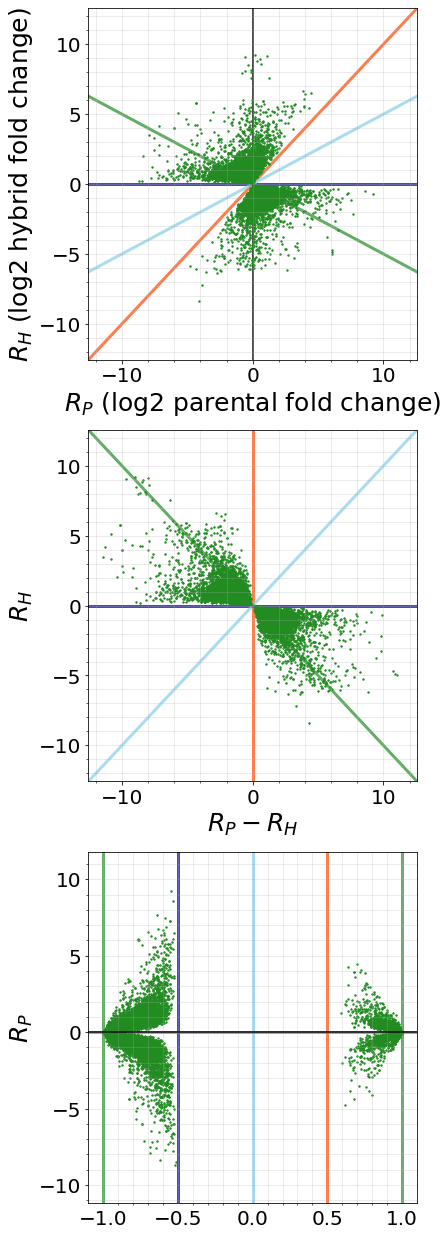

cis + trans 4807


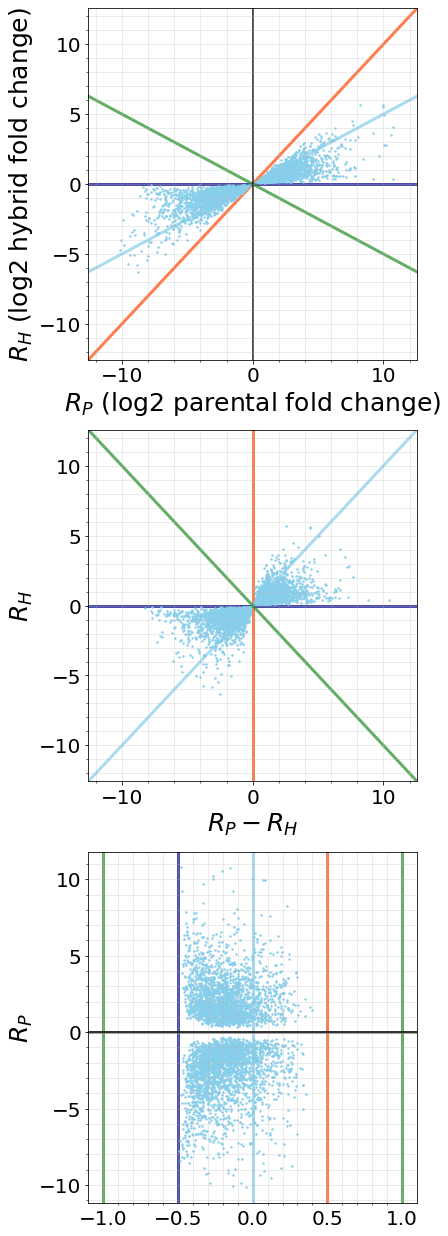

trans 51627


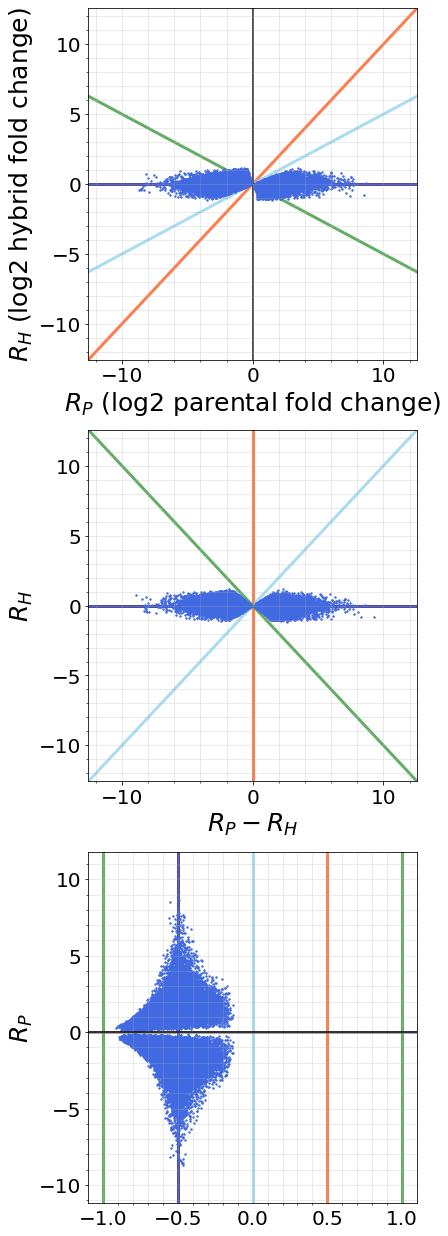

cis 17112


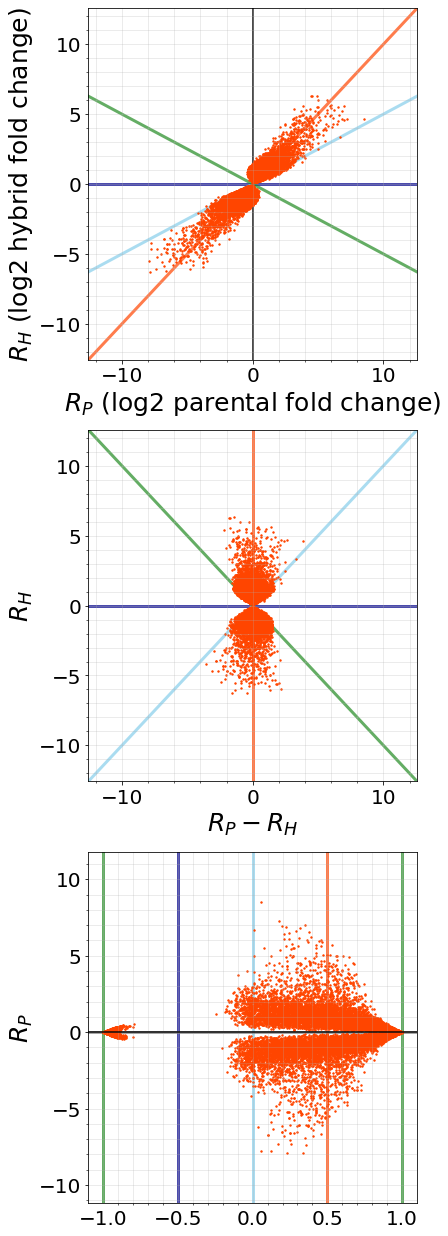

conserved 200881


/var/folders/yr/5f4ybhp15cv9yg_9r00sy7880000gn/T/ipykernel_32575/1833792731.py:24: RuntimeWarning: invalid value encountered in divide
  theta_scaled = (2/np.pi) * np.arctan(H / delta)


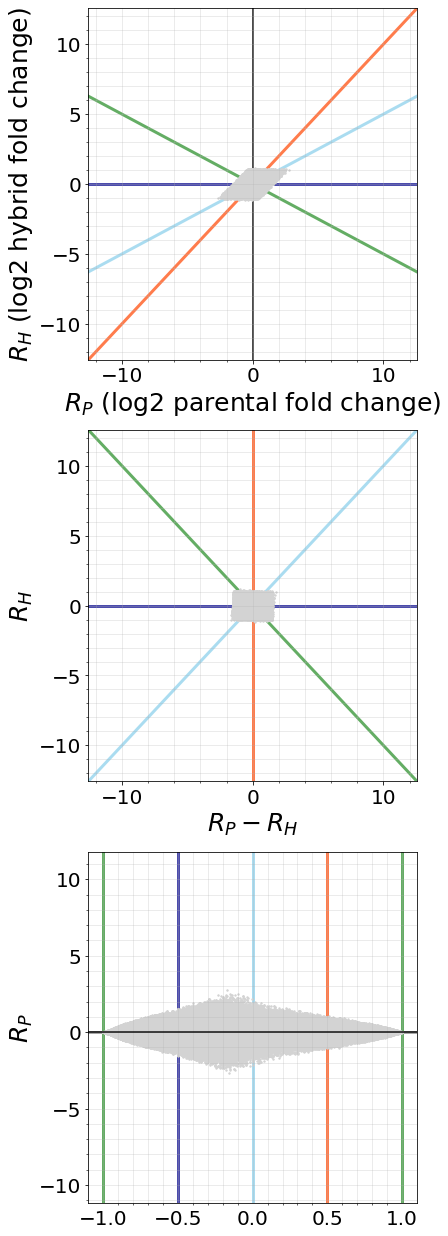

In [28]:


s = 2
alpha = 1.0
axis_fs = 25
title_fs = 18
label_fs = 20
line_color = 'black'
axis_width = 3.0
line_alpha = 0.7

num_per_reg_group_theirs = []
colors = []

for reg in reg_groups:
    fig, ax = plt.subplots(3, 1, figsize=(6, 23*(3/4)))
    label = label_dict[reg]
    color = color_dict[reg]
    df_ = df[df['new_reg_group_fdr'] == reg]
    P = df_['Parlog2FC'].values.flatten()
    H = df_['Hyblog2FC'].values.flatten()
    num_per_reg_group_theirs.append(len(H))
    colors.append(color)
    print(reg,len(P))
    delta = P - H
    theta_scaled = (2/np.pi) * np.arctan(H / delta)
    R = np.sqrt(delta**2 + H**2)
    cis_prop_reordered = theta_scaled-0.5
    cis_prop_reordered[cis_prop_reordered<=-1.0] = (cis_prop_reordered[cis_prop_reordered<=-1.0]) + 2.0

    # ax[0].scatter(P, H, s=s, alpha=alpha, color=color, label=label)
    # ax[1].scatter(delta, H, s=s, alpha=alpha, color=color)
    # ax[2].scatter(theta_scaled, P, s=s, alpha=alpha, color=color)
    # ax[2].scatter(theta_scaled, R, s=s, alpha=alpha, color=color)

    ax[0].scatter(P,H,s = s, alpha = alpha, color = color, label = label)
    ax[0].set_xlabel('$R_{P}$ (log2 parental fold change)', fontsize = axis_fs)
    ax[0].set_ylabel('$R_{H}$ (log2 hybrid fold change)', fontsize = axis_fs)

    ax[1].scatter(P-H,H,s=s,alpha=alpha,  color = color)
    ax[1].set_xlabel('$R_{P} - R_{H}$',fontsize = axis_fs)
    ax[1].set_ylabel('$R_{H}$',fontsize = axis_fs)

    ax[2].scatter(cis_prop_reordered, P ,s = s, alpha = alpha,color=color)
    # ax[2].set_xlabel(r'$\frac{2}{\pi} \theta$ (scaled angle from $trans$ axis)',fontsize=axis_fs)
    ax[2].set_ylabel('$R_{P}$',fontsize=axis_fs)

    for i in range(2):
        ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=axis_fs)
        ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=axis_fs)
        ax[i].tick_params(axis='both', labelsize=label_fs)
        ax[i].grid(which='both', alpha=0.5, linewidth=0.5)
        ax[i].minorticks_on()


        # Determine the diagonal points for the line y = x

        # ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
        # ax[i].plot([-diag_val, diag_val], np.sqrt(3)*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')
        # ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([-diag_val, diag_val]), color='black',alpha=0.7,linestyle='--')
        # ax[i].plot([-diag_val, diag_val], (1/np.sqrt(3))*np.array([diag_val, -diag_val]), color='black',alpha=0.7,linestyle='--')
        ax[i].set_xlim(-diag_val, diag_val)
        ax[i].set_ylim(-diag_val, diag_val)


    x = np.linspace(-diag_val, diag_val, 100) 
    ax_ = ax[0]
    ax_.plot(x, x, color='orangered', linewidth=axis_width,alpha = line_alpha,zorder=0)
    ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.plot(x+x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
    ax_.plot(-x-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)
    # ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')
    ax_.axvline(0, color='black', linewidth=2, alpha=0.7, linestyle='-',zorder=0)

    ax_ = ax[1]
    ax_.axvline(0, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axhline(0, color='darkblue', linewidth=axis_width, alpha = line_alpha,zorder=0)
    ax_.plot(x, x, color='skyblue', linewidth=axis_width,alpha = line_alpha,zorder=0)
    ax_.plot(-x, x, color='forestgreen', linewidth=axis_width,alpha = line_alpha,zorder=0)



    # Set additional grid lines for the third plot
    ax_ = ax[2]
    ax_.axvline(0.5, color='orangered', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(-0.5, color='darkblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(0.0, color='skyblue', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(-1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axvline(1, color='forestgreen', linewidth=axis_width, alpha=line_alpha,zorder=0)
    ax_.axhline(0, color='gray', linewidth=axis_width, alpha = line_alpha,zorder=0)
    ax_.axhline(0, color='black', linewidth=2, alpha=0.7, linestyle='-')

    ax[2].tick_params(axis='both', labelsize=label_fs)
    ax[2].tick_params(bottom=False)
    ax[2].grid(which='both', alpha=0.5, linewidth=0.5)
    ax[2].minorticks_on()

    ax[2].set_xlim(ax2_xlims)
    ax[2].set_ylim(ax2_ylims)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.savefig(f'supp2B_{reg}_fdr',dpi=450,bbox_inches='tight')
    plt.show();


## Genes per regulatory assignment

In [19]:
num_per_reg_group_theirs = []
num_per_reg_group_ours = []

for reg in reg_groups:
    num_per_reg_group_theirs.append(int(sum(df['new_reg_group_theirs']==reg)))
    num_per_reg_group_ours.append(int(sum(df['new_reg_group_fdr']==reg)))

In [20]:
colors = [color_dict[reg] for reg in reg_groups]

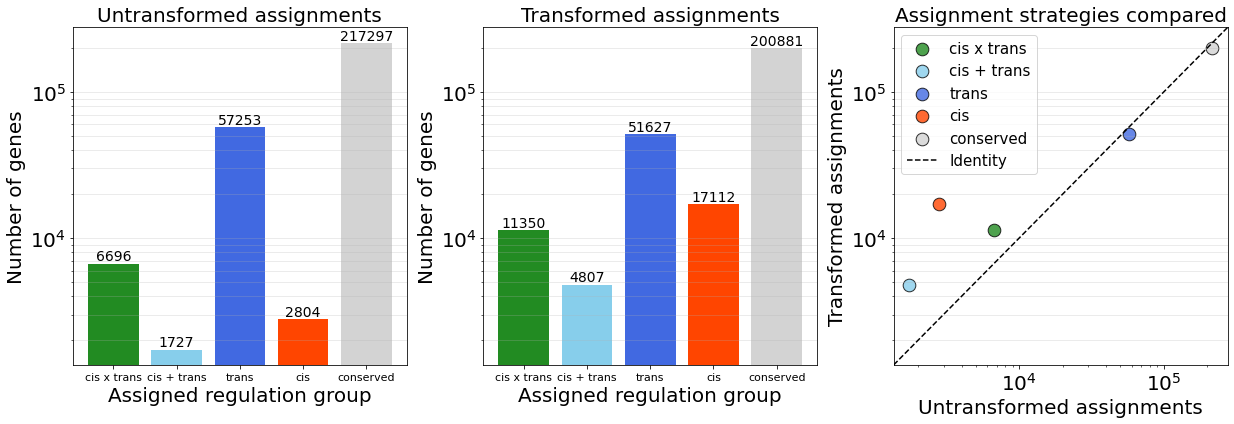

In [24]:
# barplot

fig, ax = plt.subplots(1,3,figsize = (5.75*3,6) )

axis_fs = 20
title_fs = 20
i = 0
bars = ax[i].bar(range(len(num_per_reg_group_theirs)), num_per_reg_group_theirs, color=colors)

for bar in bars:
  height = bar.get_height()
  ax[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', 
             ha='center', va='bottom', fontsize=14)

ax[i].set_xticks(range(len(num_per_reg_group_theirs)))
ax[i].set_xticklabels(reg_groups,fontsize=axis_fs-4)
ax[i].set_xlabel('Assigned regulation group',fontsize=axis_fs)
ax[i].set_ylabel('Number of genes',fontsize= axis_fs)
ax[i].set_yscale('log')
ax[i].yaxis.grid(which='both', alpha=0.5, linewidth=0.5)
ax[i].minorticks_on()
ax[i].xaxis.set_tick_params(which='minor', bottom=False)
ax[i].set_title('Untransformed assignments',fontsize=title_fs)
i = 1
bars = ax[i].bar(range(len(num_per_reg_group_ours)), num_per_reg_group_ours, color=colors)

for bar in bars:
  height = bar.get_height()
  ax[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', 
             ha='center', va='bottom',fontsize=14)

ax[i].set_xticks(range(len(num_per_reg_group_ours)))
ax[i].set_xticklabels(reg_groups,fontsize=axis_fs-4)
ax[i].set_xlabel('Assigned regulation group',fontsize=axis_fs)
ax[i].set_ylabel('Number of genes',fontsize= axis_fs)
ax[i].set_yscale('log')
ax[i].yaxis.grid(which='both', alpha=0.5, linewidth=0.5)
ax[i].minorticks_on()
ax[i].xaxis.set_tick_params(which='minor', bottom=False)
ax[i].set_title('Transformed assignments',fontsize=title_fs)
ax[i].set_ylim(ax[0].get_ylim())

i = 2
for r,reg in enumerate(reg_groups):
    
    ax[i].scatter(num_per_reg_group_theirs[r],num_per_reg_group_ours[r],
                  color = colors[r],s=160,alpha=0.8,
                  edgecolor='black',label=reg)
    
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_xlabel('Untransformed assignments',fontsize=axis_fs)
ax[i].set_ylabel('Transformed assignments',fontsize=axis_fs)
ax[i].set_title('Assignment strategies compared',fontsize=axis_fs)
ax[i].yaxis.grid(which='both', alpha=0.5, linewidth=0.5)
ax[i].minorticks_on()
lims = ax[i].get_xlim()
ax[i].plot(lims,lims,color='black',linestyle='--',label='Identity')
ax[i].legend(fontsize=15)


ax[i].set_ylim(lims)
ax[i].set_xlim(lims)


for ax_ in ax:
    ax_.tick_params(axis='x', which='major', labelsize=11)
    ax_.tick_params(axis='y', which='major', labelsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig('./figs/supp_reg_assignments_bar',dpi=450,bbox_inches='tight')
plt.show()


------

# Alluvian plot

In [ ]:
# download from https://github.com/vinsburg/alluvial_diagram/tree/master
!wget https://raw.githubusercontent.com/vinsburg/alluvial_diagram/master/alluvial.py

--2024-04-23 18:30:26--  https://raw.githubusercontent.com/vinsburg/alluvial_diagram/master/alluvial.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12728 (12K) [text/plain]
Saving to: ‘alluvial.py’

alluvial.py         100%[===================>]  12.43K  --.-KB/s    in 0s      

2024-04-23 18:30:26 (46.8 MB/s) - ‘alluvial.py’ saved [12728/12728]



In [32]:
import alluvial

In [105]:
num_overlap_dict = {r : {} for r in reg_groups}

log_num_overlap_dict = {r : {} for r in reg_groups}

for r1 in reg_groups:
  their_indices = df[df['new_reg_group_theirs'] == r1].index.values.flatten()
  for r2 in reg_groups:
    our_indices = df[df['new_reg_group_fdr'] == r2 ].index.values.flatten()
    num_overlap = len(set(their_indices).intersection(set(our_indices)))
    num_overlap_dict[r1][r2+' * '] = num_overlap
    if num_overlap!= 0:
      log_num_overlap_dict[r1][r2+' * '] = np.log(num_overlap)
    else:
      log_num_overlap_dict[r1][r2+' * '] = 0


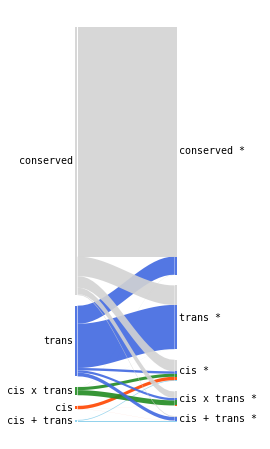

In [106]:
alluvial_colors = ['skyblue','orangered','forestgreen','royalblue','lightgray']
ax = alluvial.plot(num_overlap_dict,colors=alluvial_colors,alpha = 0.9)
fig = ax.get_figure()
fig.set_size_inches(2,8)
plt.savefig('alluvian',dpi=450,bbox_inches='tight')
plt.show()

In [33]:
# hybFC_from_counts_log1p = np.log2( ( df['P1_count'].values.flatten() + 1 ) / ( df['P2_count'].values.flatten() + 1 ) )
# parFC_from_counts_log1p = np.log2( ( df['P1_2n_count'].values.flatten() + 1 ) / ( df['P2_2n_count'].values.flatten() + 1 ) )


# hybFC_from_counts_no_log1p = np.log2( ( df['P1_count'].values.flatten()  ) / ( df['P2_count'].values.flatten()  ) )
# parFC_from_counts_no_log1p = np.log2( ( df['P1_2n_count'].values.flatten()  ) / ( df['P2_2n_count'].values.flatten()  ) )

# reported_parFC = df['Parlog2FC'].values.flatten()
# reported_hybFC = df['Hyblog2FC'].values.flatten()





# fig, axs = plt.subplots(2,2,figsize = (10,10))
# alpha = 0.3
# fs = 20

# # for parents
# axs[0,0].scatter( reported_parFC, parFC_from_counts_log1p , label = r'log2 \dfrac{X_1 + 1}{X_2 + 1}' , s = 5, color = 'darkgray', alpha = alpha)
# axs[0,1].scatter( reported_parFC, parFC_from_counts_no_log1p , label = r'log2 \dfrac{X_1 + 1}{X_2 + 1}' , s = 5, color = 'darkred', alpha = alpha)
# axs[0,0].set_xlabel('Reported parental logFC', fontsize = fs)
# axs[0,0].set_ylabel(r'log2 $ \dfrac{X_1 + 1}{X_2 + 1}$', fontsize = fs)
# axs[0,0].grid(which='both')
# axs[0,0].set_title('Parents, log1p', fontsize = fs)

# axs[0,1].set_xlabel('Reported parental logFC', fontsize = fs)
# axs[0,1].set_ylabel(r'log2 $ \dfrac{X_1}{X_2}$', fontsize = fs)
# axs[0,1].grid(which='both')
# axs[0,1].set_title('Parents, no log1p', fontsize = fs)

# axs[1,0].scatter( reported_hybFC, hybFC_from_counts_log1p , s = 5, color = 'darkgray', alpha = alpha)
# axs[1,1].scatter( reported_hybFC, hybFC_from_counts_no_log1p , s = 5, color = 'darkred', alpha = alpha)
# axs[1,0].set_xlabel('Reported hybrid logFC', fontsize = fs)
# axs[1,0].set_ylabel(r'log2 $ \dfrac{Y_1 + 1}{Y_2 + 1}$', fontsize = fs)
# axs[1,0].grid(which='both')
# axs[1,0].set_title('Hybrids, log1p', fontsize = fs)

# axs[1,1].set_xlabel('Reported hybrid logFC', fontsize = fs)
# axs[1,1].set_ylabel(r'log2 $ \dfrac{Y_1 }{Y_2 }$', fontsize = fs)
# axs[1,1].grid(which='both')
# axs[1,1].set_title('Hybrids, no log1p', fontsize = fs)


# plt.tight_layout();

In [30]:
for reg in reg_groups:
    
    df_ = df[df['reg_group'] == reg]
    print(reg)
    print(df_['new_reg_group_theirs'].unique())

conserved
['conserved']
trans
['trans']
reinforcing
['cis + trans' 'cis x trans']
compensatory
['cis x trans' 'cis + trans']
cis
['cis']
reverse
['cis x trans']
attenuating
['cis x trans' 'cis + trans']
